In [1]:
%run notebook_config

theano version: 1.0.4
pymc3 version: 3.7


# Getting started

`caustic` is a code for probabilistic modeling of single lens gravitational microlensing events. 
It is designed primarily to serve as a testbed for new approaches to modeling microlensing events rather than something that can be used in existing pipelines. 
`caustic` is built on top of the probabilistic programming language `PyMC3` which is used in many fields for the purporse of building and testing Bayesian models. 
The main feature of PyMC3 is that it enables the use of Hamiltonian Monte Carlo (HMC) via the No U-Turn Sampler (NUTS). 
HMC enables efficient sampling of high dimensional probabilistic models by utilizing the gradients of the log probability with respect the model parameters. 
These gradients are obtained through [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), a method widely used in machine learning to obtain *exact* gradientss of computer code by repeatedly apply the chain rule from calculus. 

Automatic differention (AD) is different from symbolic differentiation (like for example in Wolfram Mathematica) and the finite difference method used in numerical solvers for differential equations.
Automatic differentiation is not trivial to do so one usually relies existing libraries which implement it. 
`PyMC3` uses `Theano` under the hood. You can think of Theano as a sort of compiler that takes code written in Python, compiles it to `C`, builds a graph of all mathematical computations in the code  and propagates the gradients through every node in the graph using reverse mode automatic differentiation ([backpropagation](https://en.wikipedia.org/wiki/Backpropagation)). 
`Theano` is best known today as a predecessor to ultra popular machine learning libraries `Tensorflow` and `PyTorch` whose
main purpose is also automatic differentiation. 
Because of the requirement that all models written in `PyMC3` have to be compliant with `Theano`, building physical models
is somewhat more complicated than if we were to use `numpy`, although the API is very similar.

Check out the [PyMC3 docs](https://docs.pymc.io/notebooks/api_quickstart.html) for an introduction to `PyMC3` and probabilistic programming, [docs on Theano](http://deeplearning.net/software/theano/introduction.html) for an overview of Theano, and the very recent [exoplanet](https://exoplanet.dfm.io/en/latest/) code for building  differentiable astrophysical models on top of `PyMC3` in the context of explanet transits and radial velocity measurements. `caustic` is very similar to `exoplanet` and uses it as a dependancy. 


In this notebook, I'll walk you through loading a microlensing dataset and fitting a simple model with `caustic`.

## Loading microlensing datasets

All of the data handling is done using the `caustic.data` module. The purpose of the module is to take raw lightcurves 
provided by an observatory or collaboration and transform it into a common format which can then used within a context
of a `PyMC3` model for inference.  Here's an example where we load an OGLE light curve using the `caustic.data.OGLEData` class.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import caustic as ca

np.random.seed(42)

event_ogle = ca.data.OGLEData("../../data/OGLE-2017-BLG-0324")

The data is stored as a list of `astropy.table.Table` tables, each table corresponds to one time series observation in a certain band.

In [3]:
event_ogle.light_curves

[<Table length=626>
      HJD        mag   mag_err mask
    float64    float64 float64 bool
 ------------- ------- ------- ----
 2457069.87628   18.64   0.035 True
 2457074.88664  18.604   0.038 True
 2457075.86271  18.639   0.036 True
 2457078.86521  18.638   0.031 True
 2457082.86705   18.58   0.026 True
 2457086.89543   18.58   0.032 True
 2457090.82554  18.652   0.039 True
  2457097.8947   18.65   0.023 True
 2457100.87989  18.614   0.028 True
 2457110.80722  18.677   0.027 True
           ...     ...     ...  ...
 2458014.55412  18.645   0.034 True
 2458015.55245  18.586   0.041 True
 2458016.56098  18.607   0.036 True
  2458018.4914  18.641   0.039 True
 2458019.52922  18.593   0.027 True
 2458020.56318  18.613   0.034 True
 2458026.52622  18.645   0.052 True
  2458029.5112  18.641   0.049 True
 2458030.51879  18.696   0.039 True
 2458040.49979  18.614   0.055 True]

Each table contains metadata information about the observatory and filter used

In [4]:
for table in event_ogle.light_curves:
    print(table.meta)

{'filter': 'I', 'observatory': 'OGLE'}


Plotting the data is straightforward

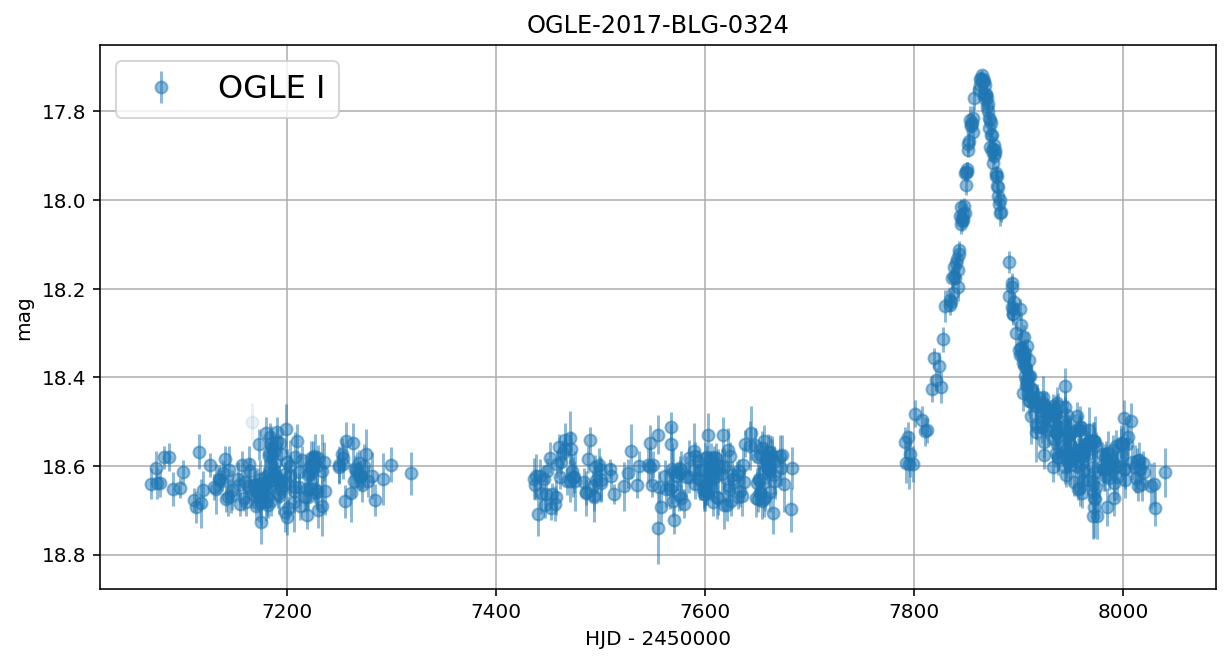

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot(ax)

The times of observation are specified in Helocentric Julian Days (HJD), the source brightness is either units of magnitudes or flux (defined such that a magnitude of 22 corresponds to unit flux). 

In [6]:
event_ogle.units = 'fluxes'

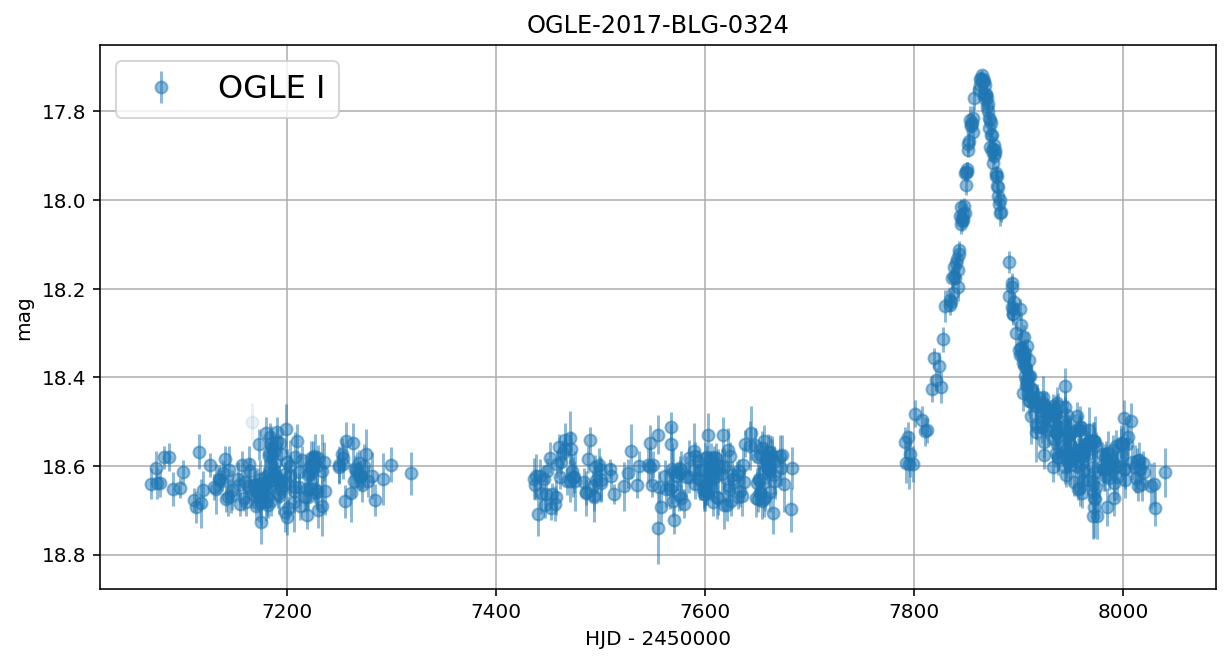

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot(ax)

The coordinates of an event are stored as a `astropy.coordinates.SkyCoord` object

In [8]:
event_ogle.event_coordinates

<SkyCoord (ICRS): (ra, dec) in deg
    ( 264.61391667, -29.90372222)>

You can also get the data in a standardized format where all light curves are converted to fluxes and standardized to zero
median and unit variance

In [9]:
standardized_data = event_ogle.get_standardized_data()
standardized_data

[<Table length=626>
    HJD            flux           flux_err   
  float64        float64          float64    
 ---------- ----------------- ---------------
 7069.87628   -0.146581222379  0.101194880196
 7074.88664  -0.0404763560482  0.113588563846
 7075.86271   -0.143594760276  0.104186780064
 7078.86521   -0.141146881047  0.089779925443
 7082.86705    0.030960028291 0.0794167559969
 7086.89543   0.0314495066675 0.0977653441168
 7090.82554   -0.180686906212  0.111541606797
  7097.8947   -0.176271671295 0.0658606499698
 7100.87989  -0.0711215388054 0.0828946818377
 7110.80722   -0.252367129576 0.0754253274367
        ...               ...             ...
 8014.55412   -0.161092076113 0.0978476380807
 8015.55245   0.0140922362723  0.124623619075
 8016.56098  -0.0496318551675  0.107303185788
  8018.4914   -0.149076743775   0.11267742054
 8019.52922 -0.00843225890283 0.0814924180113
 8020.56318  -0.0676525458059  0.100774429169
 8026.52622   -0.159040327379  0.149796801571
  8029.5112   

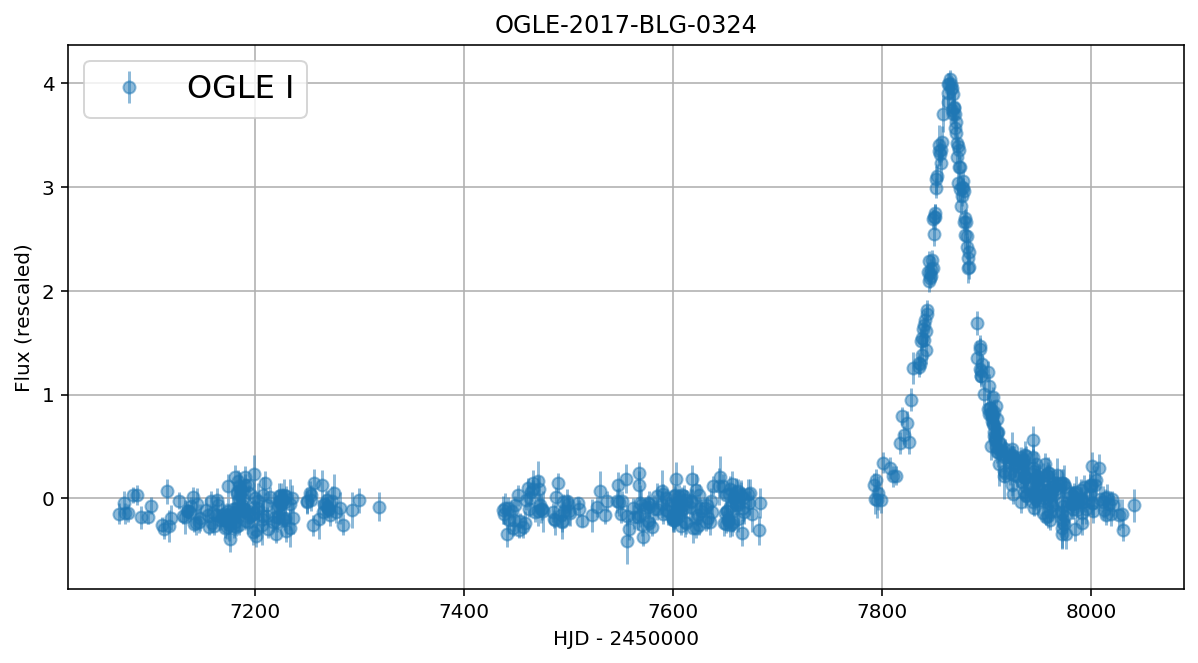

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot_standardized_data(ax)

It's possible to add different datasets together as `event_combined = event1 + event2`.

## Fitting a simple model

All models we build with `caustic` are just `PyMC3` models, all `caustic` does is that it provides some extra functionality
specific to microlensing. The user initializes a base model `caustic.models.SingleLensModel` inherits from `pymc3.model.Model` class and provides basic functionality such as transforming the data into `theano` tensors and methods for computing the likelihood.  One can then build on that model by initializing `PyMC3` random variables and calling methods
for computing the trajectory of the lens and the resulting magnification.

Let's first initialize a `SingleLensModel` object which takes a `caustic.data` object as an input, transforms the data to a standardized format where all of the light curves are rescaled to zero median and unit standard deviation and stores the data as theano tensors. We also need to specify the noise model

In [11]:
# Initialize a SingleLensModel object
pspl_model = ca.models.SingleLensModel(event_ogle) 

The data is stored as one `theano.tensor` for time observations $\{\mathbf{t}_j\}$, fluxes $\{\mathbf{F}_j\}$
and reported uncertainties $\{\boldsymbol{\sigma}_h\}$ where $j$ goes over all bands. Since the number of data points for a given light curve will in general depend on the band $k$, for reasons of computational efficiency, we stack observations in a single matrix of shape $(N_\mathrm{bands}, N_\mathrm{max})$ where $N_\mathrm{bands}$ is the number of bands and $N_\mathrm{max}$ is the dimension of the light curve with the greatest number of data points such that the missing values are replaced by zeros. We keep track of the locations of the missing values by also storing a masking array of the same dimension.

In [12]:
import theano.tensor as T

# Time
T.shape(pspl_model.t).eval() # .eval() evaluates the theano computation graph

array([  1, 626])

In [13]:
# Flux
T.shape(pspl_model.F).eval() # .eval() evaluates the theano computation graph

array([  1, 626])

In [14]:
# Error bars
T.shape(pspl_model.sig_F).eval() # .eval() evaluates the theano computation graph

array([  1, 626])

In [15]:
# Mask
T.shape(pspl_model.mask).eval() # .eval() evaluates the theano computation graph

array([  1, 626])

The model we are going to fit is the simplest in microlensing. It models the magnification of a background source star
by a single point lens assuming uniform colinear motion between the observer, the lens and the source. The magnification 
is then given by the following simple expression

$$
A(u)=\frac{u^2+2}{u\sqrt{u^2+4}}
$$

where the trajectory $u(t)$ is 
$$
u(t)=\sqrt{u_0^2+\left(
\frac{t-t_0}{t_E}\right)^2}
$$

The predicted flux  $\mathbf{f}_j$ in the $j$-th band is then 
$$    
\mathbf{f}_j=\boldsymbol{\Phi}\,\mathbf w_j
$$

where the matrix $\boldsymbol{\Phi}$ is defined by

$$   
\boldsymbol{\Phi}=\left(\begin{array}{cc}
   {\tilde{A}_{1}\left(t_{1}\right)} & {1} \\
   {\tilde{A}_{2}\left(t_{2}\right)} & {1} \\
   {\vdots} & {\vdots} \\
   {\tilde{A}_{N}\left(t_{N}\right)} & {1}
   \end{array}\right) 
$$

with $\tilde{A}(t)\equiv (A(t)-1)/(A(t_0)-1)$ and $\mathbf{w}_j$ is a vector
of linear parameters

$$
\mathbf{w}_j=\left(\begin{array}{c}{\Delta F}_j \\
   {F_{\mathrm{base}, j}}\end{array}\right) 
$$

where the parameter $\Delta F_j$ represents the difference between the flux at peak magnification and the baseline flux
$F_\mathrm{base, j}$ in the $j$-th band.


We assume that the likelihood function for the $j$-th band is a multivariate gaussian with mean $\mathbf{f}_j$ and a covariance matrix $\mathbf C$.
The likelihood for the time series data in the $j$-th band is then

$$
p(\mathbf{F}_j|\boldsymbol{\theta})\sim\mathcal{N}(\mathbf{F}_j;
    \mathbf{f}_j,\mathbf{C}_j)
$$

where the symbol $\mathcal{N}$ denotes a multivariate normal distribution. In this example, we take the covariance matrix to be diagonal 

$$
\mathbf{C}_j=\mathrm{diag}\left(\sigma_{1,j}^2, \sigma_{2,j}^2,\dots,\sigma_{N,j}^2\right)
$$

where the elements on the diagonal are the squares of the uncertainties for each point. In the the `gaussian_processes` 
notebook we relax this assumption by modelling off diagonal terms with a GP. Since the reported uncertainties in microlensing are generally underestimated we'll introduce a constant rescaling by a parameter $c$
$$
\tilde{\sigma}_{i,j}=c\,\sigma_{i,j}
$$


The total likelihood for data observed in multiple bands is then the product of the
individual likelihoods for each band because the the noise properties are
conditionally independent on the parameters between the different bands.
$$
p(\{\mathbf{F}\}^{J}_{j=1}|\boldsymbol{\theta})=\prod_{j=1}^J
  p(\mathbf{F}_j|\boldsymbol{\theta})
$$

First, we initialize the linear flux parameters as `PyMC3` random variables. The shape of these parameters has to be
$(N_\mathrm{bands}, 1)$. It's good practice to make use of the `testval=` keyword for every RV in `PyMC3` to initialize the RV because MCMC
is extremely sensitive to initial values of the model parameters.

In [16]:
import pymc3 as pm

n_bands = len(event_ogle.light_curves)
BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
BoundedNormal_1 = pm.Bound(pm.Normal, lower=1.) 

with pspl_model:
    # Initialize linear parameters   
    Delta_F = BoundedNormal('Delta_F', 
        mu=T.zeros(n_bands),
        sd=50.*T.ones(n_bands),
        testval=5.*T.ones(n_bands),
        shape=(n_bands))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=0.6*T.ones(n_bands),
        testval=T.zeros(n_bands),
        shape=(n_bands))

To print all free parameters in the model, we do the following

In [17]:
pspl_model.vars

[Delta_F_lowerbound__, F_base]

The `_lowerbound__` and `_interval__` words mean that the original bounded parameters (for example restricted to be positive) have been transformed using a deterministic transform such that they end up being defined on the entire domain of real numbers. `PyMC3` does this by default to improve sampling efficiency. In the final trace containing the samples one can access both the transformed and the original parameters.

Let's specify the rest of the model

In [18]:
with pspl_model:
    # Initialize non-linear parameters
    ## Posterior is multi-modal in t0 and it's critical that the it is 
    ## initialized near the true value
    t_0 = pm.Uniform('t_0', pspl_model.t_min, pspl_model.t_max,
        testval=ca.utils.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    teff = BoundedNormal('t_eff', mu=0., sd=365., testval=20.)
    
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", teff/u_0) 
    m_source, g = ca.utils.compute_source_mag_and_blend_fraction(event_ogle, Delta_F, F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(pspl_model.t)
    
    # Compute the magnification
    mag = pspl_model.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = Delta_F*mag + F_base
    
    # We allow for rescaling of the error bars by a constant factor
    c = BoundedNormal_1('c', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c*pspl_model.sig_F)**2
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = pspl_model.compute_log_likelihood(pspl_model.F - mean, var_F)
    pm.Potential('log_likelihood', ll)

In [19]:
pspl_model.vars

[Delta_F_lowerbound__,
 F_base,
 t_0_interval__,
 u_0_lowerbound__,
 t_eff_lowerbound__,
 c_lowerbound__]

We're now ready to sample the model with NUTS. We use Dan Foreman-Mackey's modification to the default `PyMC3` sampler `exoplanet.get_dense_nuts_step()` which includes an improved tuning schedule. By default, the NUTS implementation in `PyMC3` assumes a diagonal mass matrix. The modified sampling procedure in `exoplanet` uses a dense matrix which is tuned in 4 short runs to estimate the inverse of the covariance matrix of the model parameters. Effectively this means that the parameter space is rescaled such that the posterior is as close as possible to a multivariate Gaussian with an identity matrix as the covariance matrix. For more details of the imporoved tuning schedule, see [here](https://dfm.io/posts/pymc3-mass-matrix/). 

In [20]:
import exoplanet as xo

with pspl_model:
    # Print initial logps
    initial_logps = [RV.logp(pspl_model.test_point) for RV in pspl_model.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace = pm.sample(tune=500, draws=1000, cores=4, step=xo.get_dense_nuts_step())

Initial values of log priors: [array(-3.226523626198718), array(-0.40811290943868195), array(-1.9090798469309613), array(-3.6292109565291044), array(-3.8246048329742135), array(-2.3364828943245635)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, t_eff, u_0, t_0, F_base, Delta_F]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:07<00:00, 841.84draws/s] 
The acceptance probability does not match the target. It is 0.917326653333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.91317687182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.919073536508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.904761736385, but should be close to 0.8. Try to increase the number of tuning steps.


To check how the sampling turned out, we can use built in methods from `PyMC3`

In [21]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
F_base__0,-0.104518,0.006742,0.000086,-0.117684,-0.091167,5775.219066,0.999590
Delta_F__0,4.036066,0.032439,0.000475,3.971145,4.098353,5055.680648,0.999583
t_0,7864.494492,0.142043,0.001954,7864.218919,7864.766999,5577.122237,1.000082
u_0,0.358080,0.034814,0.000536,0.290066,0.425068,4882.827747,0.999875
t_eff,17.372086,0.580678,0.008525,16.265045,18.527349,4974.089922,0.999656
t_E,48.821212,3.223538,0.049167,42.833827,55.427428,4759.241213,1.000006
m_source__0,19.081654,0.140522,0.002138,18.814974,19.365813,4961.465950,0.999876
g__0,0.535063,0.196442,0.002950,0.139560,0.905589,4967.179192,0.999863
c__0,1.209871,0.034580,0.000512,1.143927,1.278791,5343.656676,1.000132


Not bad, we have thousands of effective samples for less than a minute of sampling time.

We can also plot a traceplot of the chain

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


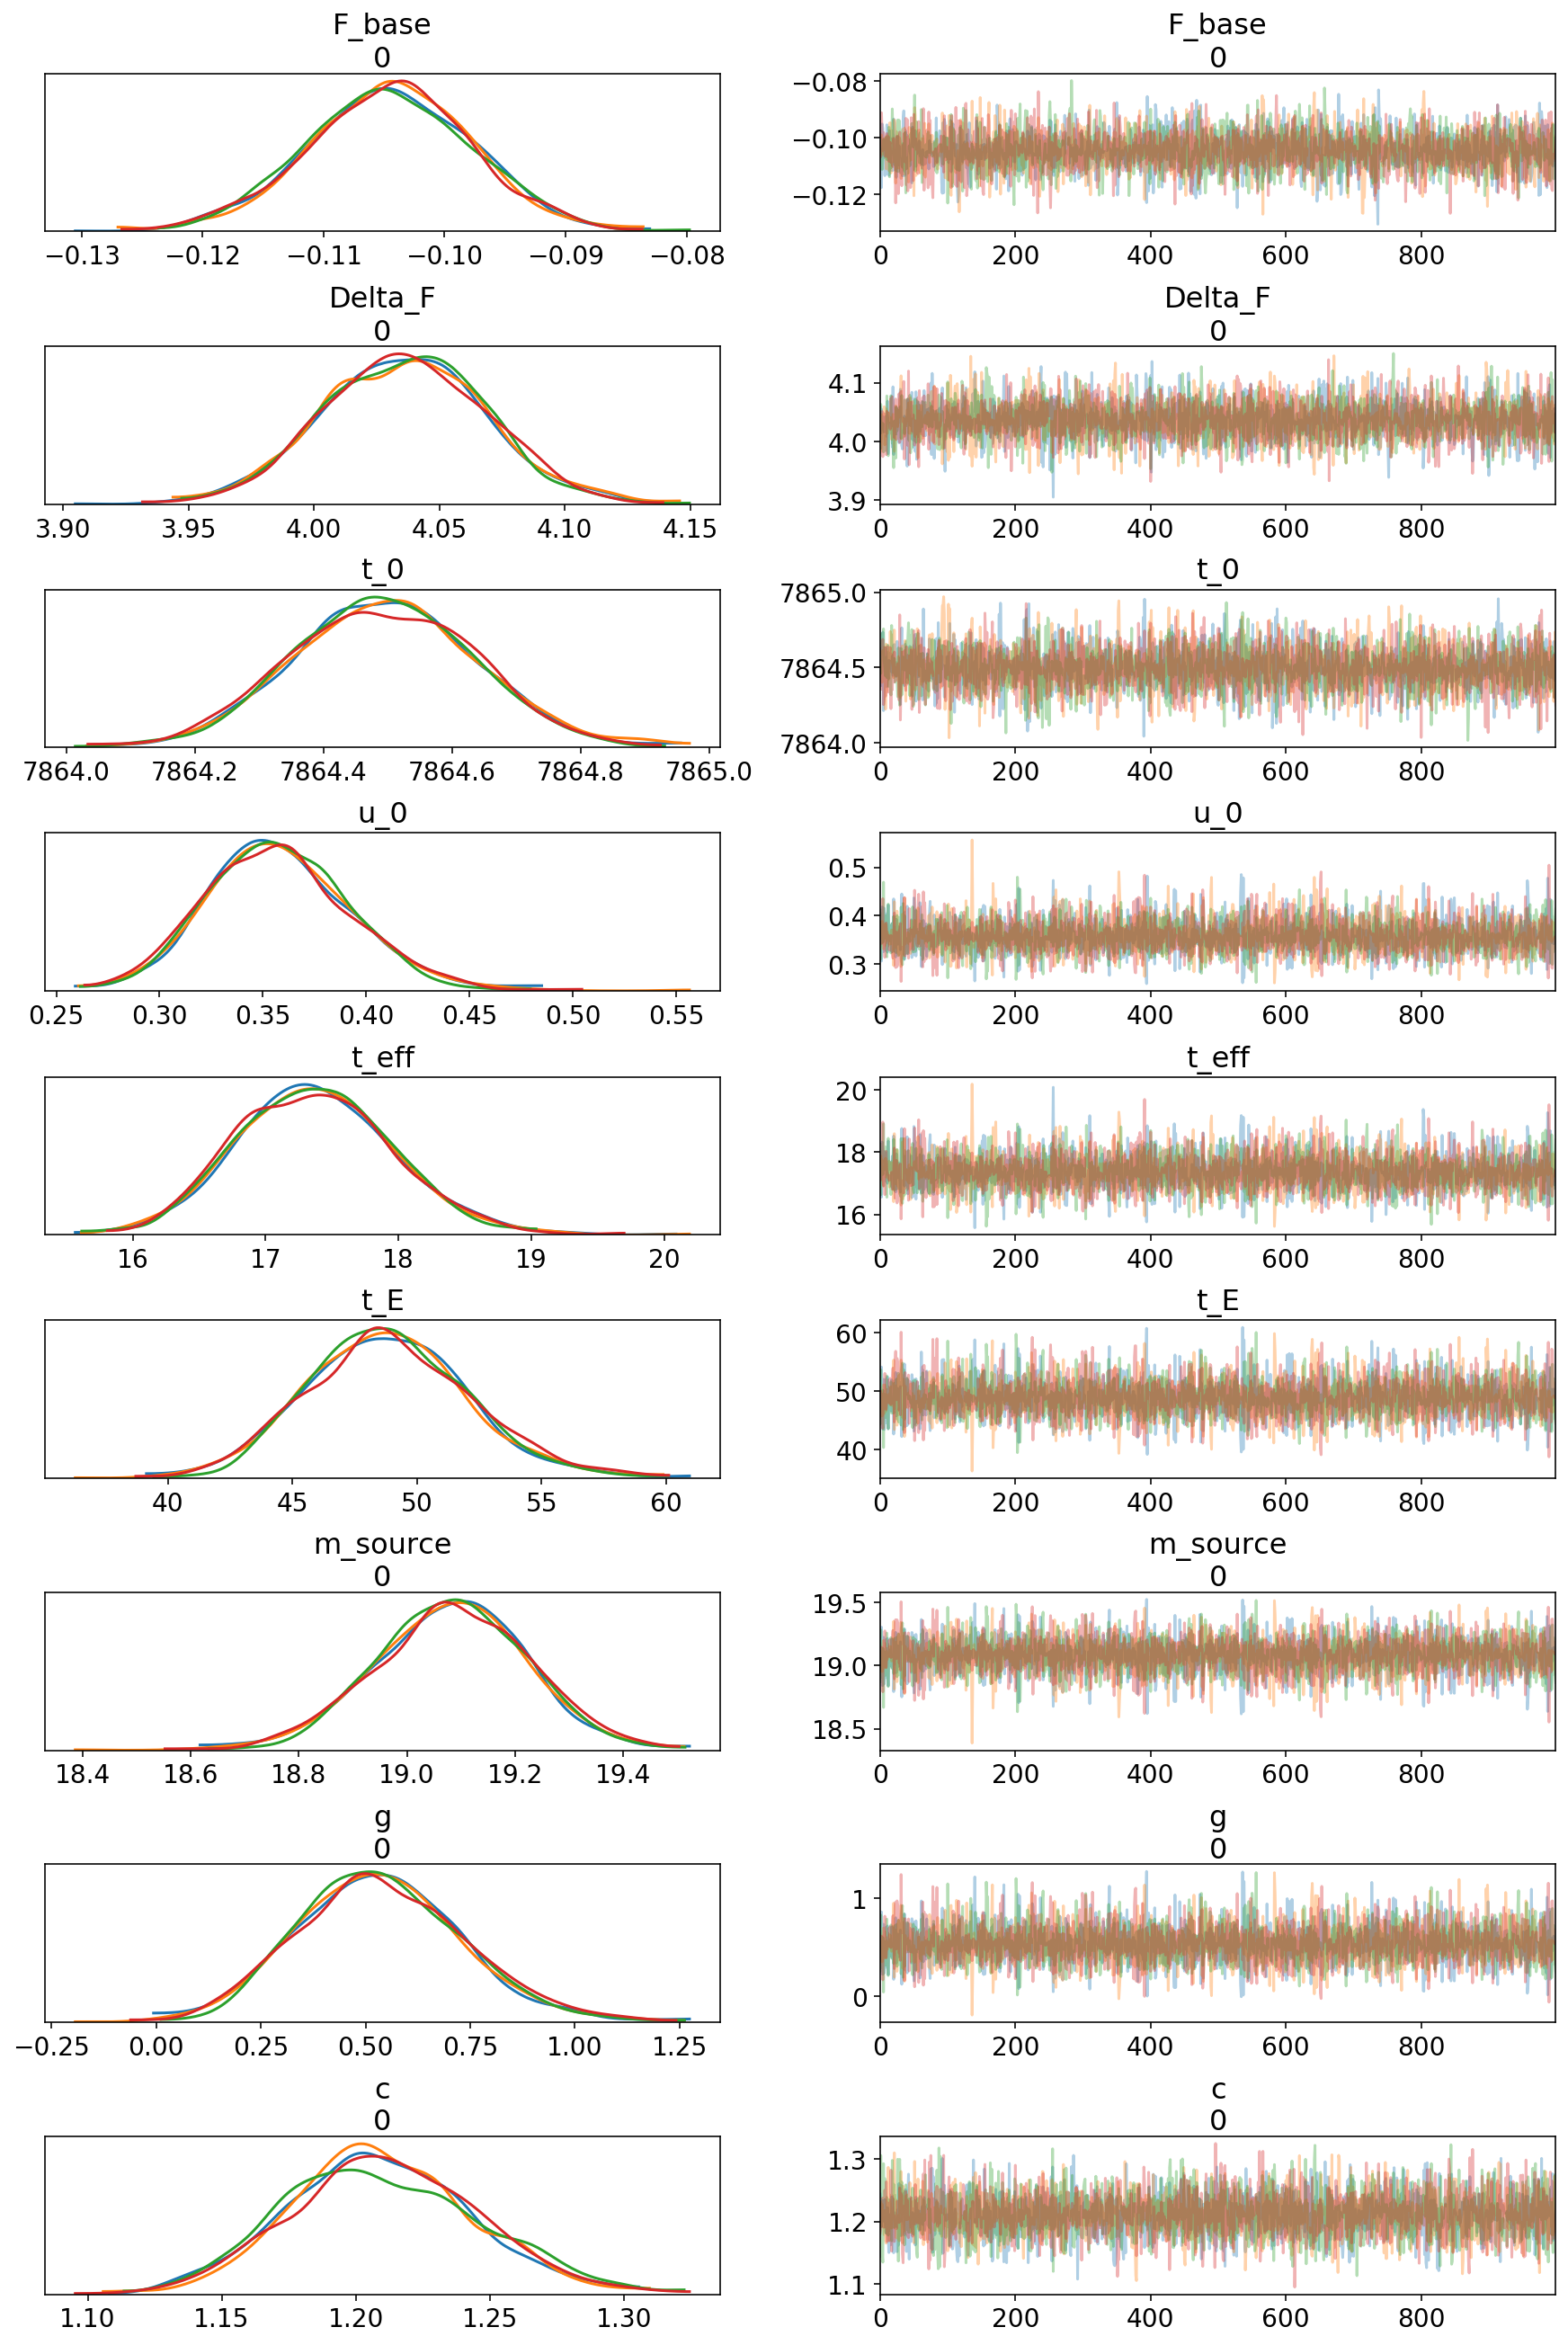

In [22]:
pm.traceplot(trace);

The traceplot also includes the deterministic variables we've specified in the model. In this case we've added a variable
`m_source`, the posteior over the source star brightness in magnitudes and the blending ratio `g` which is the ratio of the background flux due to other unresolved stars in the vicinity of the source star and the source star flux.

Let's check the autocorrelation times of the chains

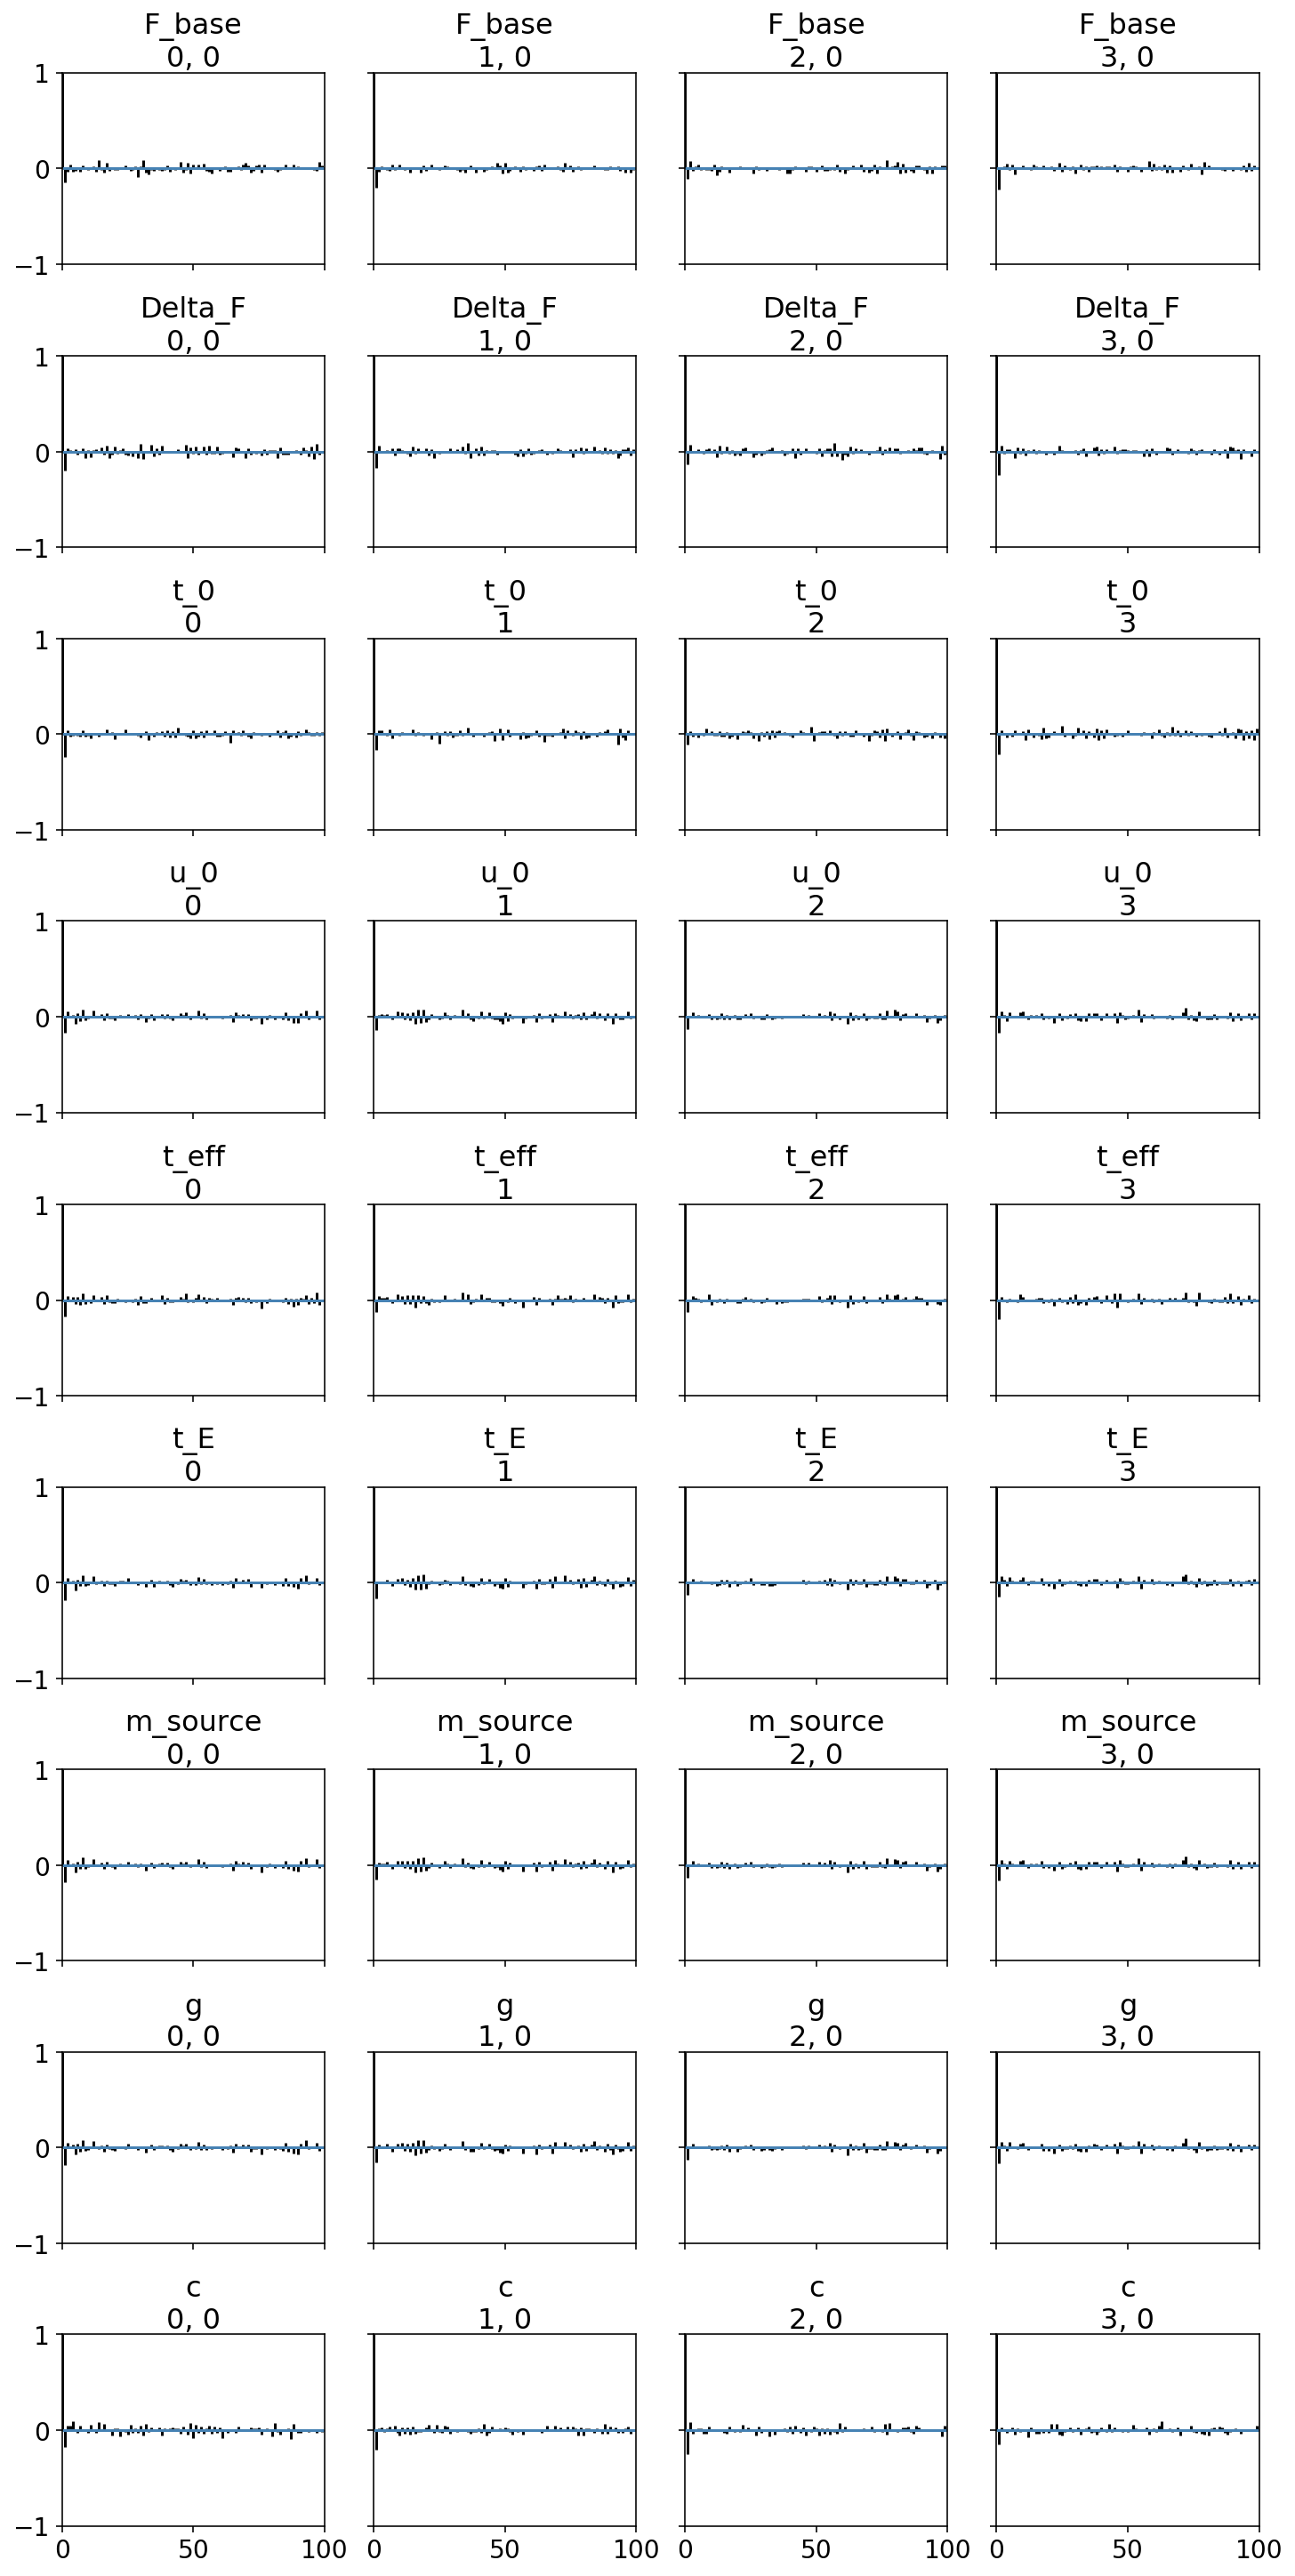

In [35]:
pm.autocorrplot(trace, figsize=(10, 20));

and plot the posterior means and highest posterior density intervals

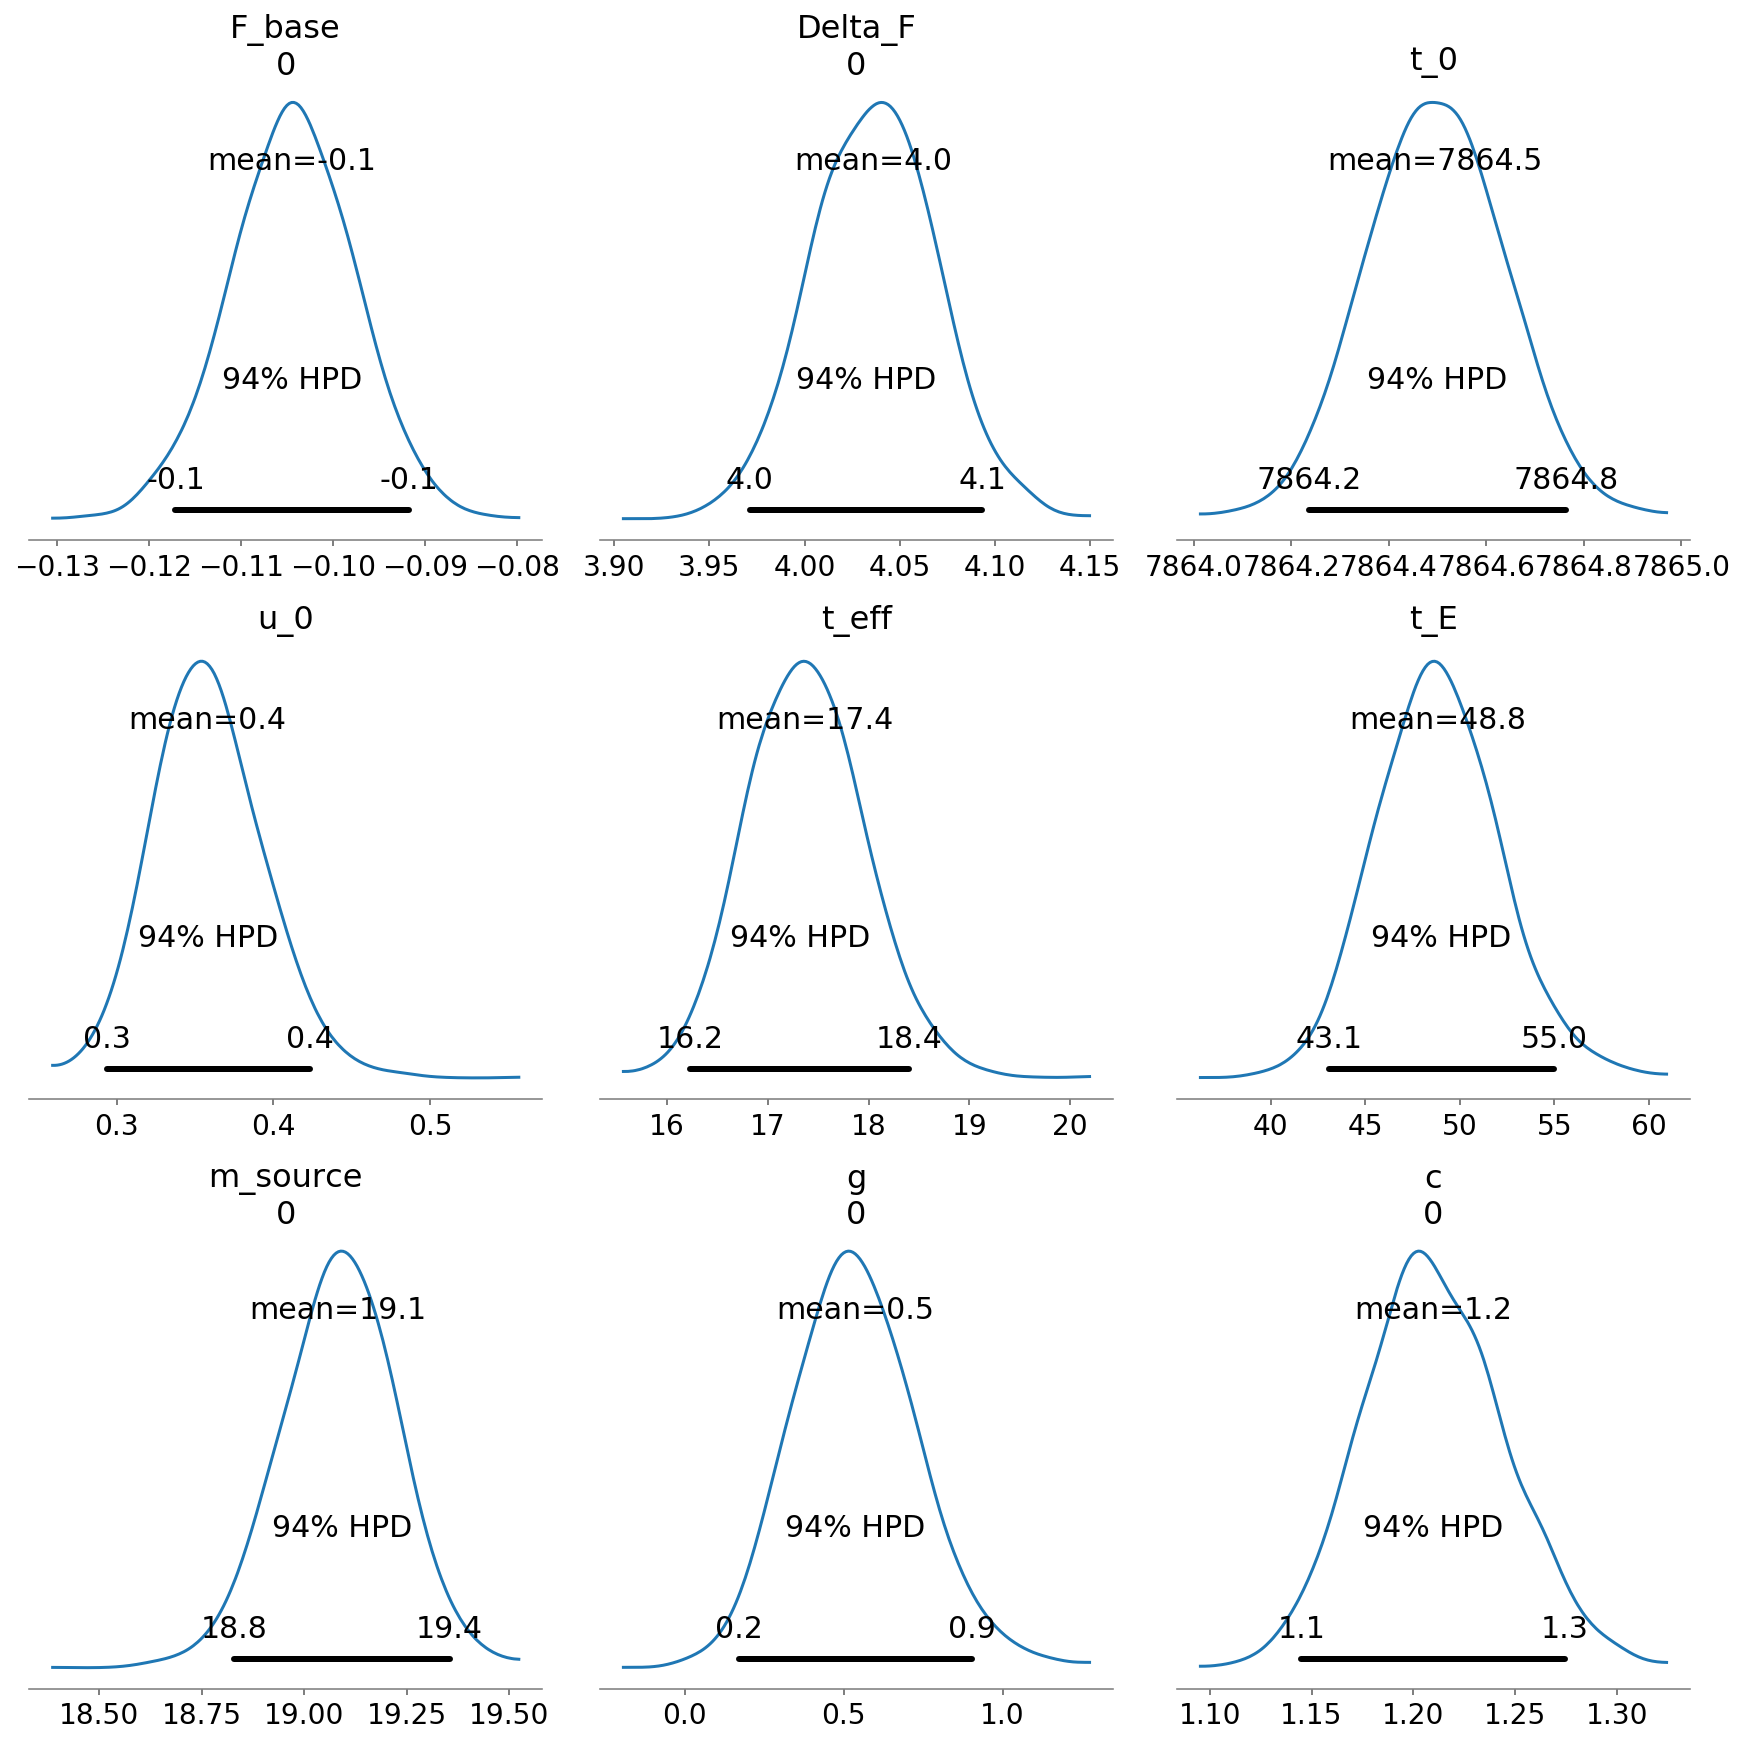

In [40]:
pm.plot_posterior(trace, figsize=(12, 12));

and a corner plot

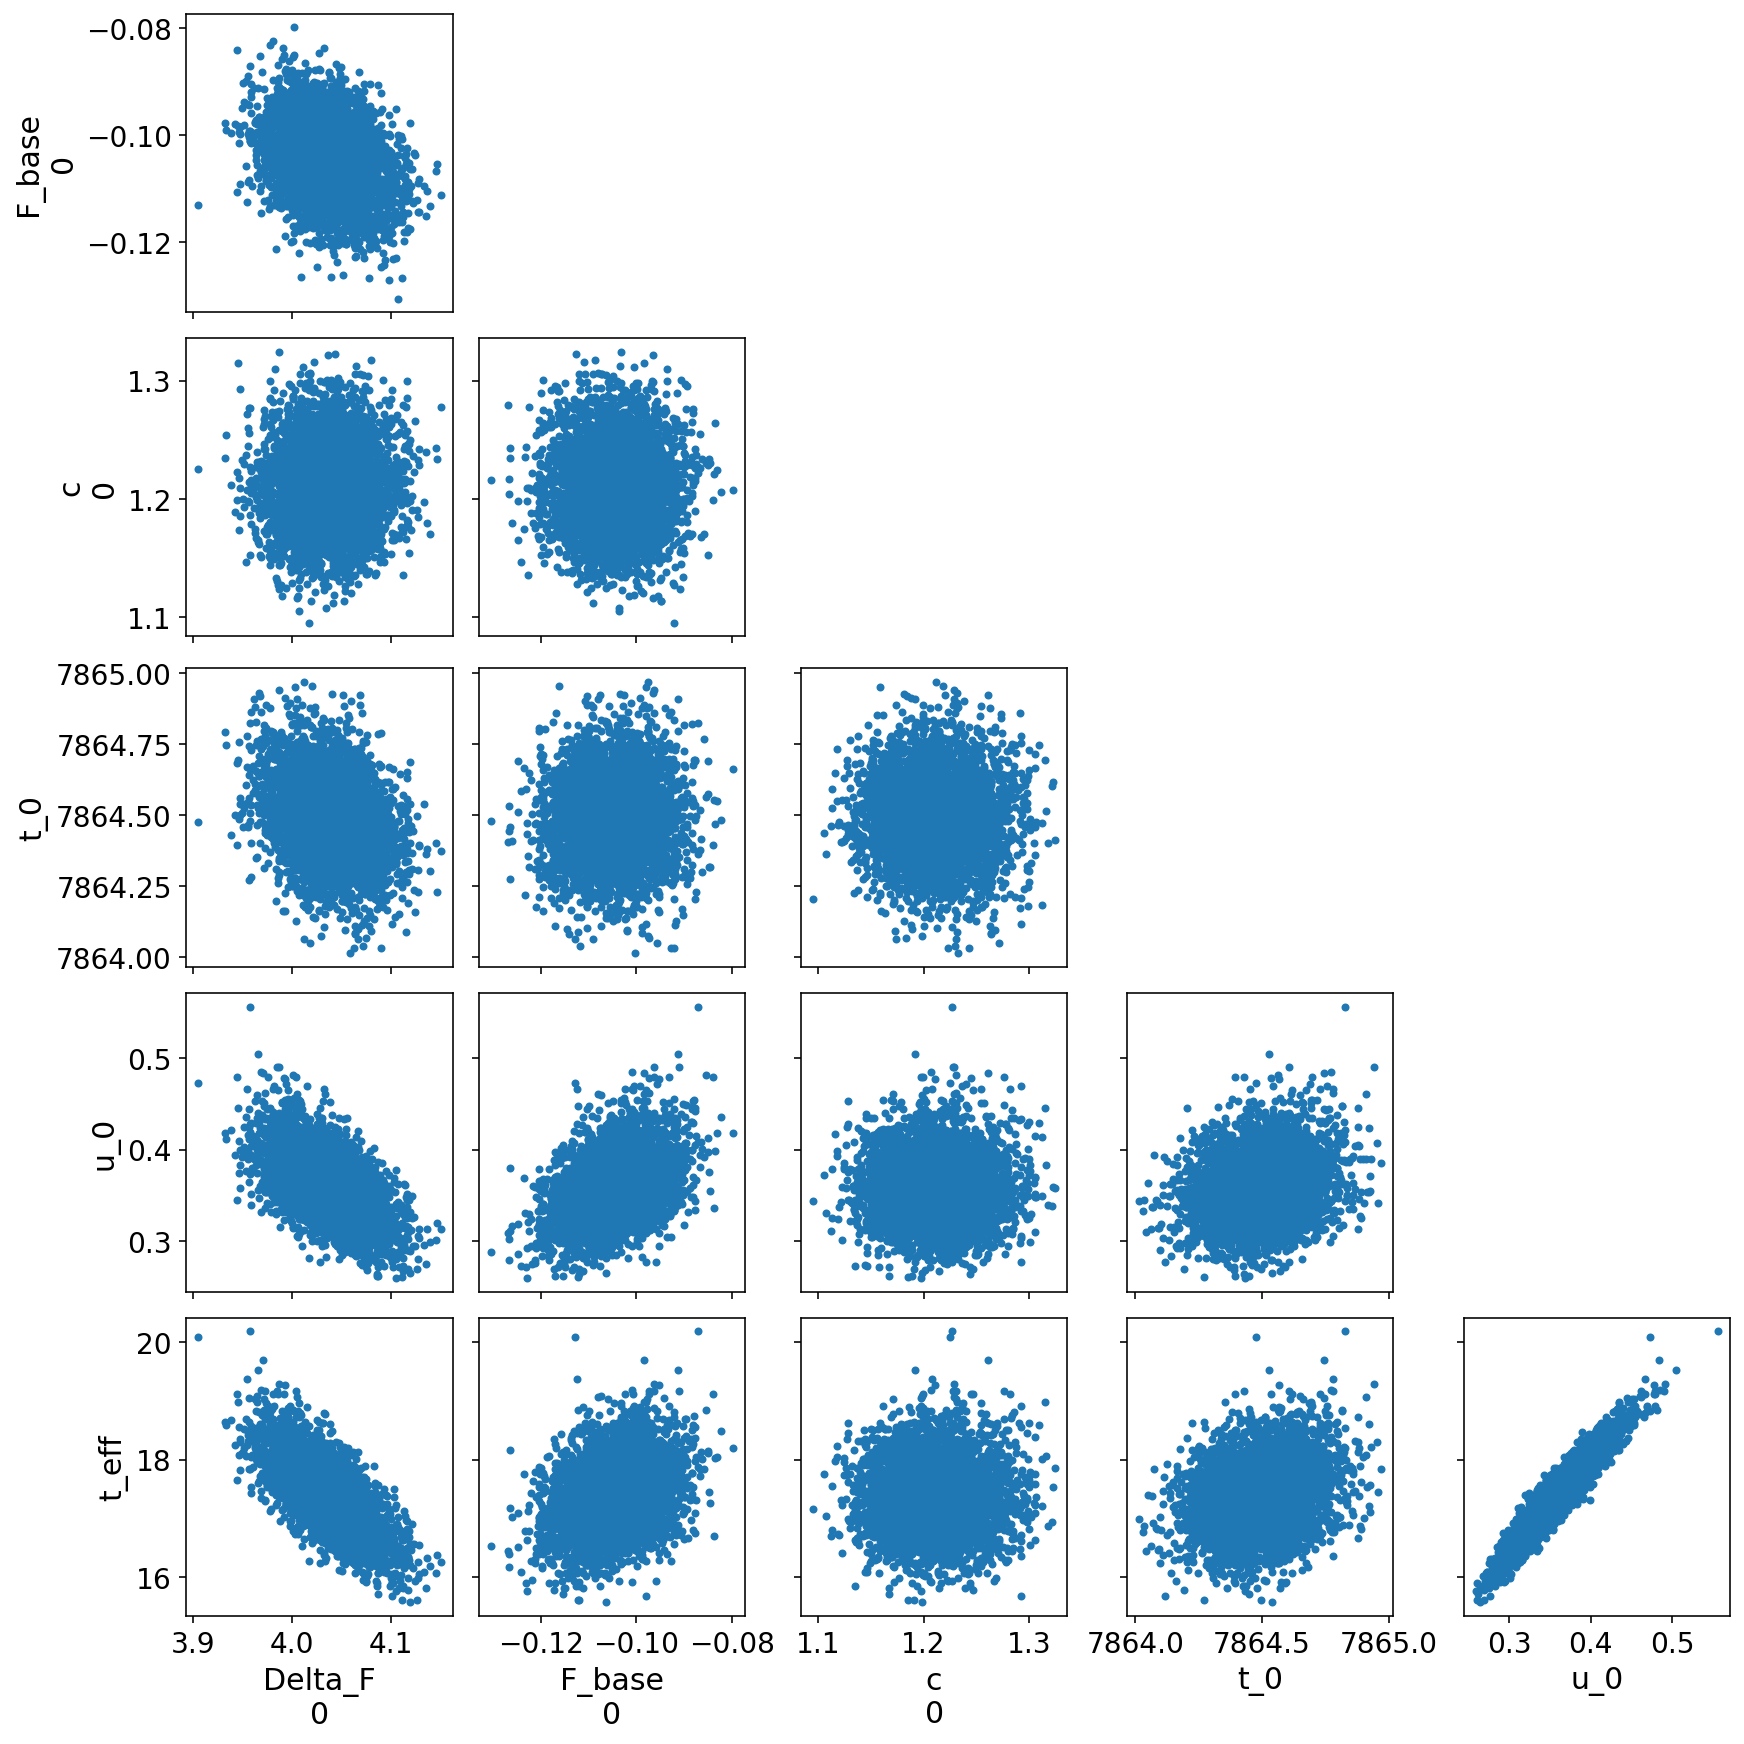

In [42]:
pm.pairplot(trace, figsize=(12, 12),
            var_names=['Delta_F', 'F_base', 'c', 't_0', 'u_0', 't_eff']);

When interpreting this plot, we have to remember that the actual sampling happens in the sapace of the transformed parameters while the `pm.pairplot()` function plots the samples in the original space.


Finally, we can plot posterior realizations of the model in data space. This is more complicated than it sounds because we have to evaluate the model prediction which is a `theano.tensor` for multiple draws from the posterior. To do this, we recompute the model prediction tensor for a denser grid in time, and pass that tensor to the function `plot_model_and_residuals` defined in `caustic.utils`. Internally, the prediction tensor is then evaluated for different
parameter dictionaries corresponding to different samples from the posterior.

In [26]:
with pspl_model:
    # Create dense grid
    t_dense = np.tile(np.linspace(pspl_model.t_min, pspl_model.t_max, 2000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense) 
    
    # Compute the trajectory of the lens
    u_dense = trajectory.compute_trajectory(t_dense_tensor)
    
    # Compute the magnification
    mag_dense = pspl_model.compute_magnification(u_dense, u_0)
    
    # Compute the mean model
    mean_dense = Delta_F*mag_dense + F_base

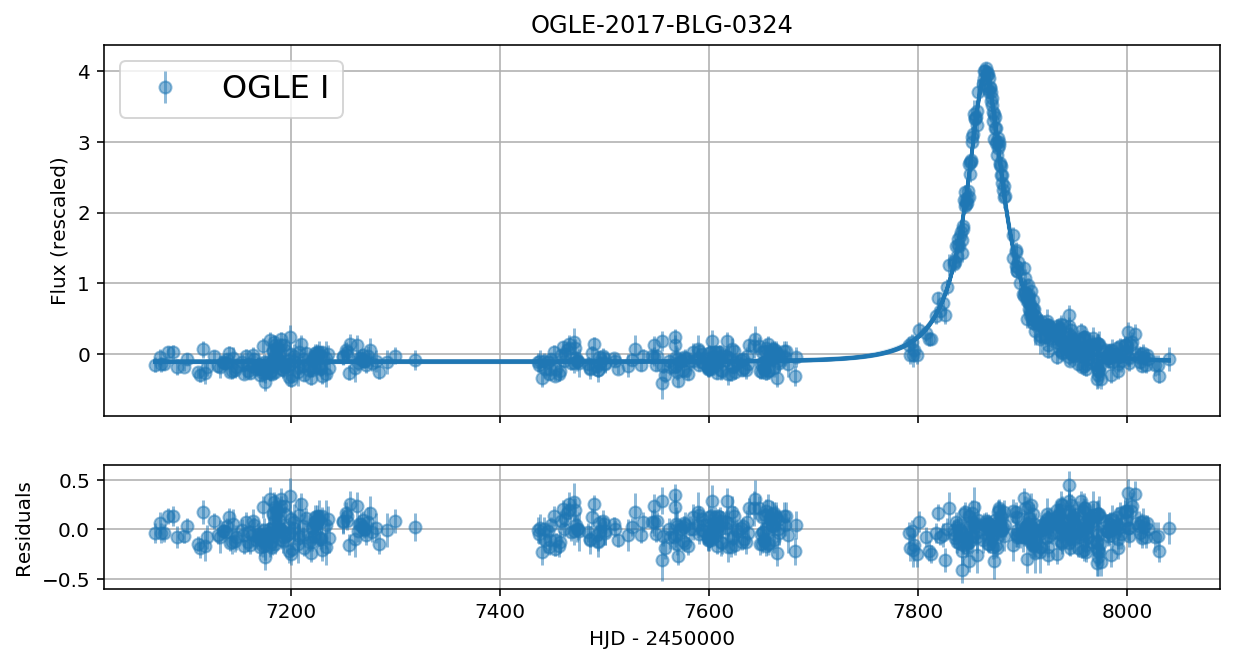

In [39]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(10, 8), sharex=True)

ca.plot_model_and_residuals(ax, event_ogle, pspl_model, trace, t_dense_tensor, mean_dense, n_samples=50)

## Marginalizing over the linear flux parameters

Instead of sampling both in the linear flux parameters, we can analytically marginalize over them and sample the marginalized posterior. To do this, we need to call the `compute_marginalized_likelihood` method.

In [28]:
# Initialize a SingleLensModel object
pspl_model_marginalized = ca.models.SingleLensModel(event_ogle) 

with pspl_model_marginalized:
    # Initialize non-linear parameters
    t_0 = pm.Uniform('t_0', pspl_model_marginalized.t_min, pspl_model_marginalized.t_max,
        testval=ca.utils.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    teff = BoundedNormal('t_eff', mu=0., sd=365., testval=20.)
    
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", teff/u_0) 
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(pspl_model_marginalized.t)
    
    # Compute the magnification
    mag = pspl_model_marginalized.compute_magnification(u, u_0)
    
    # We allow for rescaling of the error bars by a constant factor
    c = BoundedNormal_1('c', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c*pspl_model_marginalized.sig_F)**2
    
    # Prior matrix for the linear parameters
    sig_Delta_F = 20.
    sig_F_base = 0.1
    L_diag = T.as_tensor_variable(np.array([sig_Delta_F, sig_F_base])**2.)
    L = T.nlinalg.diag(L_diag)

    # Compute the marginalized log-likelihood  
    ll = pspl_model_marginalized.compute_marginalized_log_likelihood(mag, var_F, L)
    pm.Potential('log_likelihood', ll)

In [29]:
pspl_model_marginalized.vars

[t_0_interval__, u_0_lowerbound__, t_eff_lowerbound__, c_lowerbound__]

In [30]:
with pspl_model_marginalized:
    # Print initial logps
    initial_logps = [RV.logp(pspl_model_marginalized.test_point) for RV in pspl_model_marginalized.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace_marginalized = pm.sample(tune=500, draws=500, cores=2, step=xo.get_dense_nuts_step())

Initial values of log priors: [array(-1.9090798469309613), array(-3.6292109565291044), array(-3.8246048329742135), array(-2.3364828943245635)]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, t_eff, u_0, t_0]
Sampling 2 chains: 100%|██████████| 2000/2000 [14:53<00:00,  5.20draws/s]
The acceptance probability does not match the target. It is 0.901194414875, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.912614301126, but should be close to 0.8. Try to increase the number of tuning steps.


In [31]:
pm.summary(trace_marginalized)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t_0,7864.495246,0.144098,0.004272,7864.194871,7864.760091,1059.278472,0.999686
u_0,0.356540,0.033956,0.001240,0.290155,0.420973,818.934851,1.000674
t_eff,17.348272,0.570134,0.020234,16.222450,18.390898,821.638701,1.000136
t_E,48.948909,3.124054,0.112599,42.783685,54.855410,844.528930,1.001266
c__0,1.204093,0.034754,0.001127,1.129330,1.266552,1020.444821,0.999959


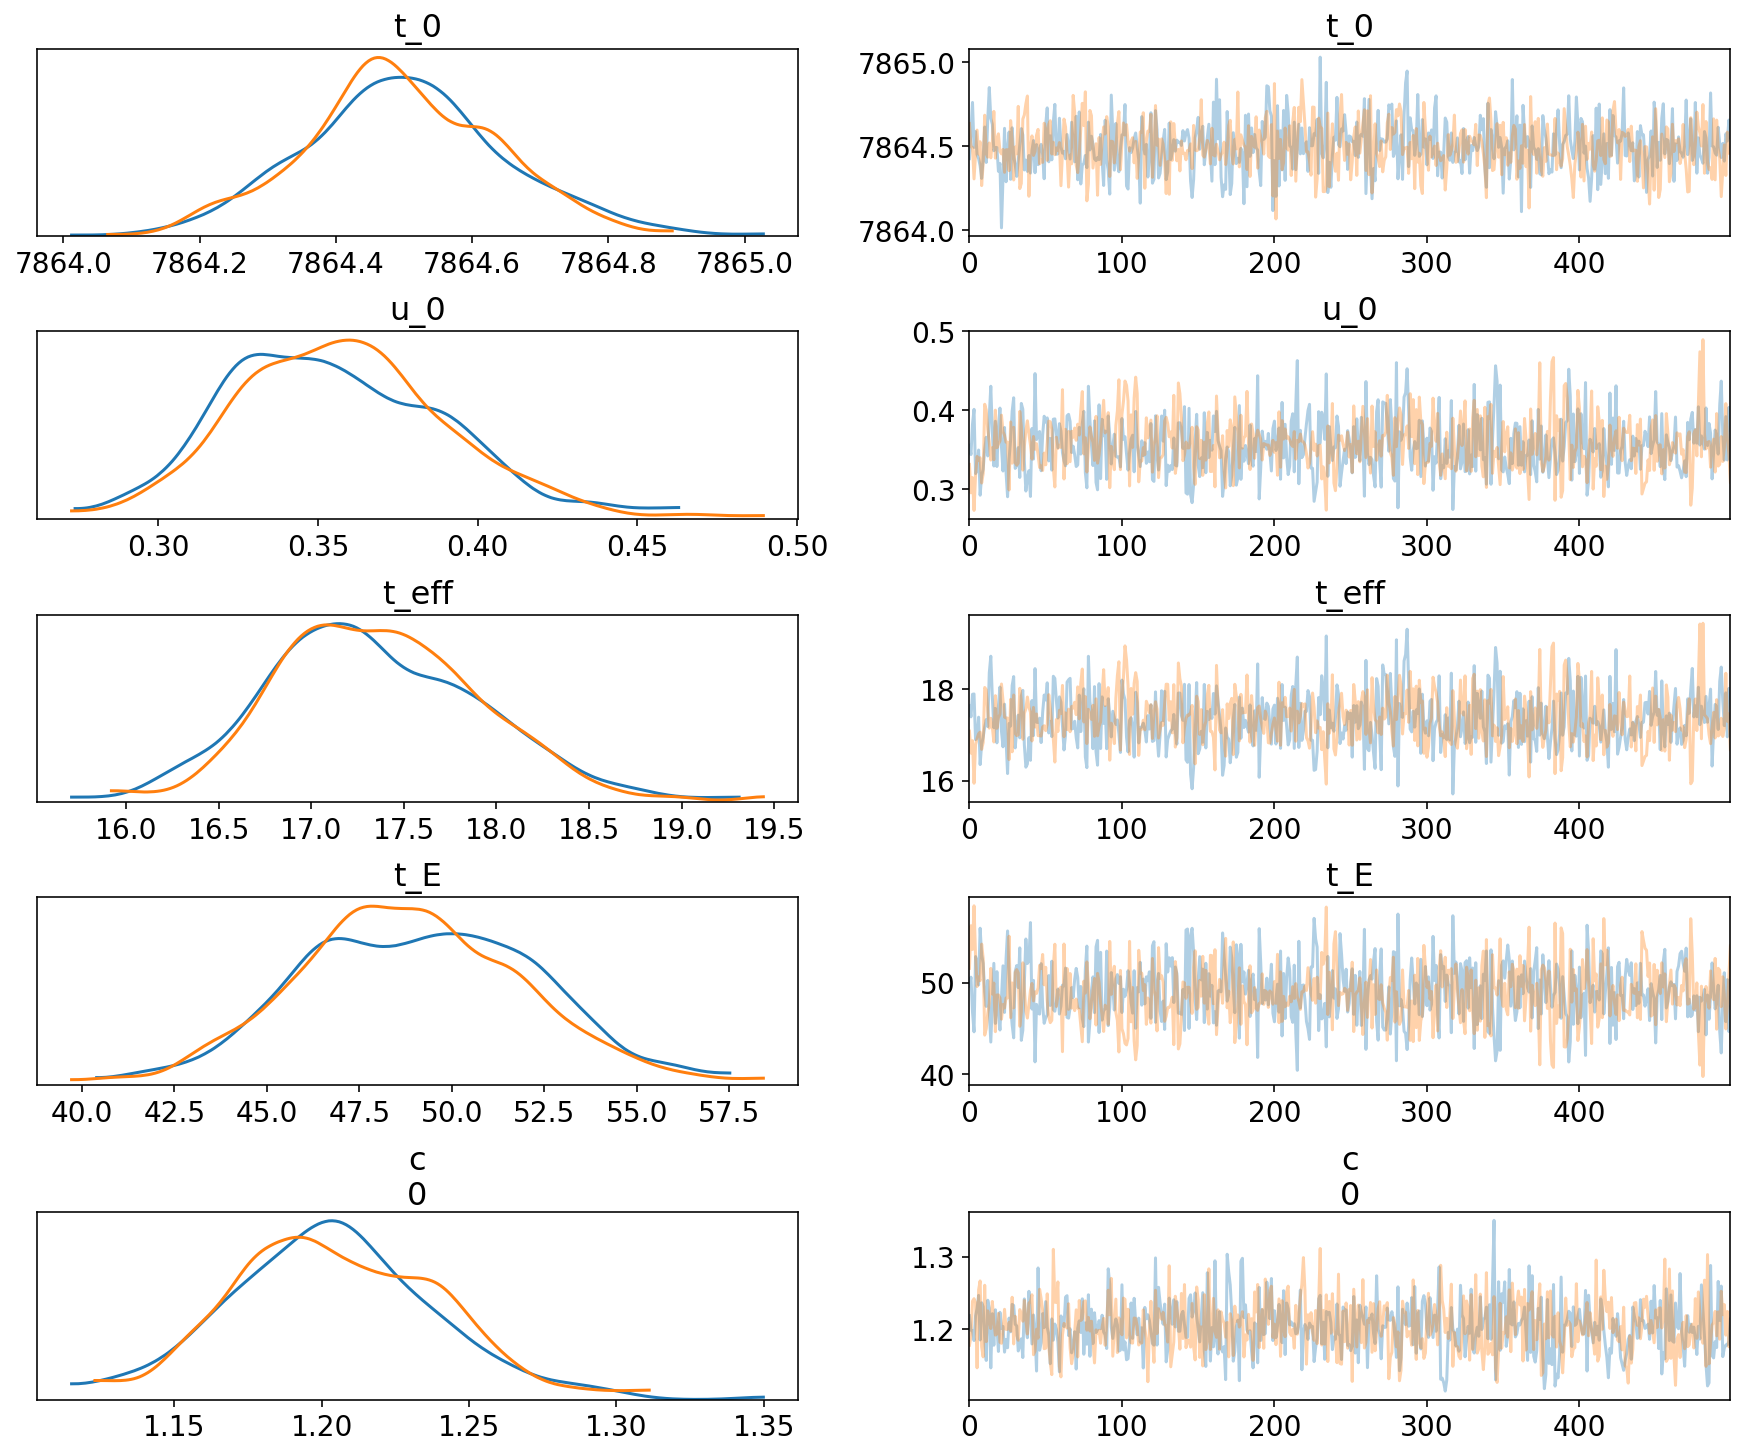

In [32]:
pm.traceplot(trace_marginalized);

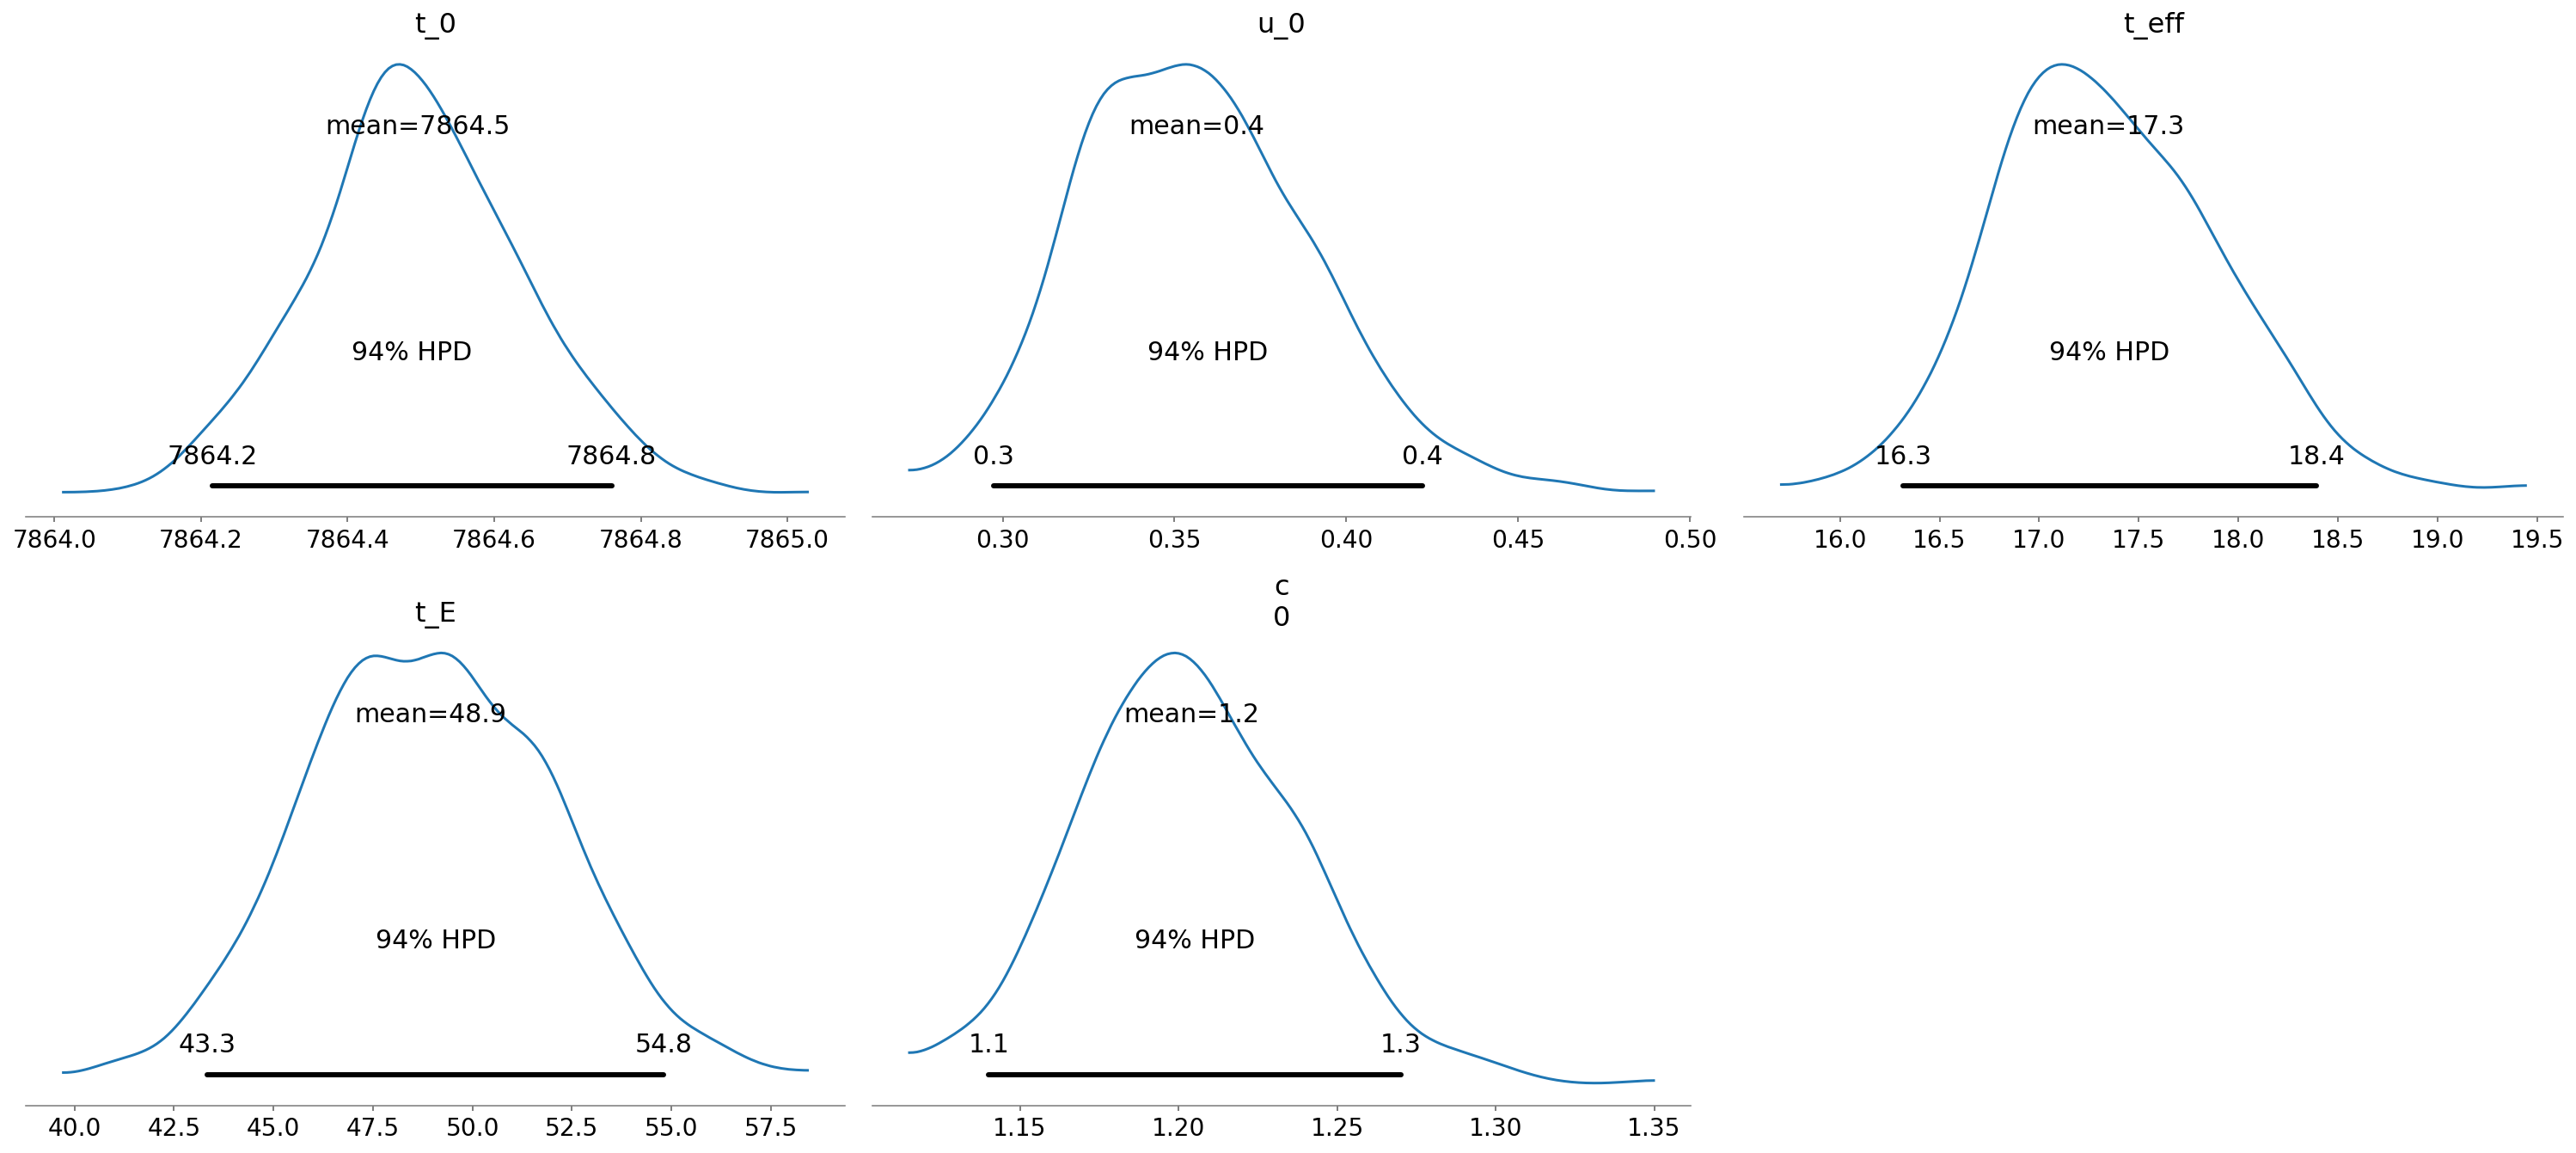

In [33]:
pm.plot_posterior(trace_marginalized, figsize=(12, 12));

As expected, we obtain the same posteriors over the non-linear space as if we sampled in the full space. Unfortunately, the sampling is many orders of magnitude slower because of all additional matrix operations we need to do. There are tricks we can use to speed it up if the covariance matrix of the data is diagonal, but I recommend just sampling in the full space instead. HMC can handle it.